In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *

In [2]:
import numpy as np
import scipy
import os
import sys
from sklearn.metrics import confusion_matrix
import pandas as pd

In [3]:
from IPython.core.interactiveshell import InteractiveShell
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

This notebook explains the solution for dataset uploaded in kaggle site for [plant seedling identification](https://www.kaggle.com/c/plant-seedlings-classification/data). Another notebook will be prepared for keras model and we will then compare the fast.ai result with keras.

Each image has a filename that is its unique id. The dataset comprises 12 plant species. The goal of the competition is to create a classifier capable of determining a plant's species from a photo. The list of species is as follows:
- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

API credentials

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. Place this file in the location ~/.kaggle/kaggle.json (on Windows in the location C:\Users\<Windows-username>\.kaggle\kaggle.json - you can check the exact location, sans drive, with echo %HOMEPATH%). You can define a shell environment variable KAGGLE_CONFIG_DIR to change this location to $KAGGLE_CONFIG_DIR/kaggle.json (on Windows it will be %KAGGLE_CONFIG_DIR%\kaggle.json).

For your security, ensure that other users of your computer do not have read access to your credentials. On Unix-based systems you can do this with the following command:

chmod 600 ~/.kaggle/kaggle.json

You can also choose to export your Kaggle username and token to the environment:

export KAGGLE_USERNAME=datadinosaur

export KAGGLE_KEY=xxxxxxxxxxxxxx

In addition, you can export any other configuration value that normally would be in the $HOME/.kaggle/kaggle.json in the format 'KAGGLE_' (note uppercase).
For example, if the file had the variable "proxy" you would export KAGGLE_PROXY and it would be discovered by the client.
    
 

In [4]:
# ! kaggle competitions download -c histopathologic-cancer-detection -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [5]:
# Command-Line Interface

# The zipfile module provides a simple command-line interface to interact with ZIP archives.

# If you want to create a new ZIP archive, specify its name after the -c option and then list the filename(s) that should be included:

# $ python -m zipfile -c monty.zip spam.txt eggs.txt

# Passing a directory is also acceptable:

# $ python -m zipfile -c monty.zip life-of-brian_1979/

# If you want to extract a ZIP archive into the specified directory, use the -e option:

# $ python -m zipfile -e monty.zip target-dir/

# For a list of the files in a ZIP archive, use the -l option:

# $ python -m zipfile -l monty.zip



## Multiclassification

In [6]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True)
    Download `url` if it doesn't exist to `fname` and un-tgz to folder `dest`



Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to one tag.

In [7]:
# URL.CANCER_DATA = '/home/nbuser/courses/fast-ai/course-v3/nbs/data/oxford-iiit-pet'
# path = untar_data(URL.CANCER_DATA); path
path = '/home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling'

In [8]:
np.random.seed(42)

src_plant = (ImageItemList.from_folder(path, folder='train', suffix='.png')
       .random_split_by_pct(0.2)
       .label_from_folder())

In [10]:
tfms = get_transforms(flip_vert=True, max_lighting=0.3, max_zoom=1.05, max_warp=0.)

In [11]:
data = (src_plant.transform(tfms, size=64)
        .databunch().normalize(imagenet_stats))

In [73]:
data.c

13

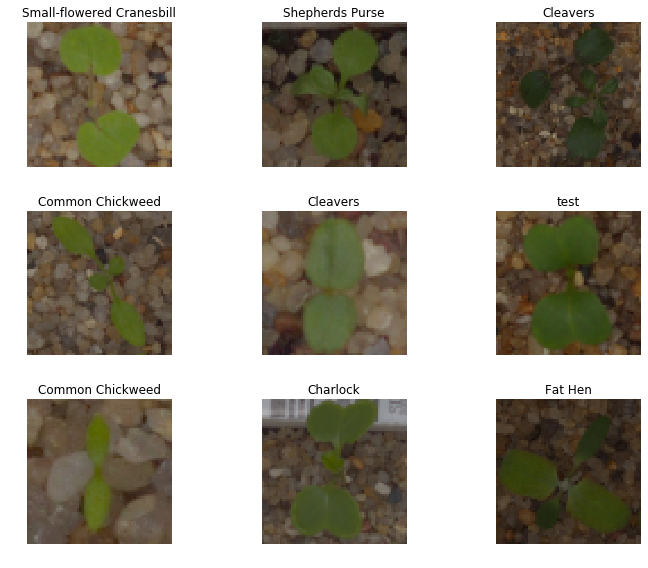

In [37]:
data.show_batch(rows=3, figsize=(10,8))

## A first model (ResNet101, px=64)

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

In [11]:
tfms_2 = get_transforms(flip_vert=True, max_lighting=0.3, max_warp=0.)

data_2 = (src_plant.transform(tfms_2, size=64)
        .databunch().normalize(imagenet_stats))


In [12]:
plant_celllearn_101 = create_cnn(data_2, models.resnet101, metrics=(accuracy,error_rate))

In [13]:
plant_celllearn_101.crit = 'CrossEntropyLoss'
#learn.crit = ssd_loss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


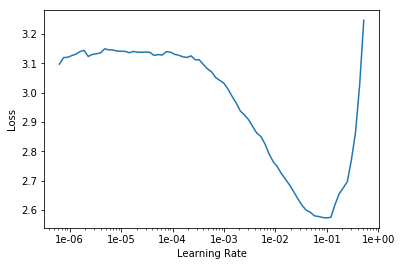

In [43]:
plant_celllearn_101.lr_find(); 
plant_celllearn_101.recorder.plot()

In [44]:
lr = 0.01

In [45]:
plant_celllearn_101.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,error_rate
1,2.066100,4.887820,0.488267,0.511733
2,1.630876,2.405643,0.605596,0.394404
3,1.237154,2.342452,0.685018,0.314982
4,1.024357,2.027932,0.716606,0.283394
5,0.891828,3.490342,0.720217,0.279783


In [47]:
plant_celllearn_101.save('plant_seedlings_stage_1_fast_ai')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


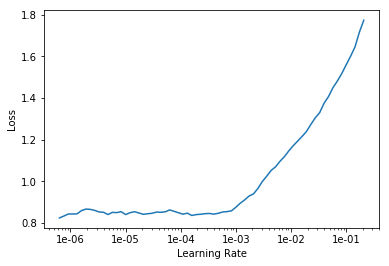

In [48]:
plant_celllearn_101.load('plant_seedlings_stage_1_fast_ai')
plant_celllearn_101.unfreeze()
plant_celllearn_101.lr_find()
plant_celllearn_101.recorder.plot()

In [49]:
#plant_celllearn_101.fit_one_cycle(5, max_lr=slice(1e-6,1e-5))
plant_celllearn_101.fit_one_cycle(5, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.813811,3.278002,0.722022,0.277978
2,0.799246,1.414185,0.737365,0.262635
3,0.723800,1.220452,0.768051,0.231949
4,0.627383,1.130039,0.784296,0.215704
5,0.580660,1.140259,0.786101,0.213899


In [50]:
plant_celllearn_101.save('plant_seedlings_stage_2_fast_ai')

### Checking the model status


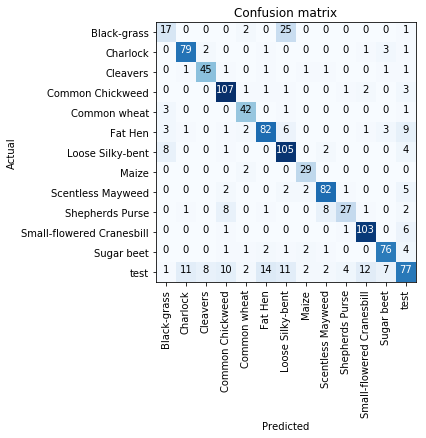

In [51]:
interp = ClassificationInterpretation.from_learner(plant_celllearn_101)
interp.plot_confusion_matrix(figsize=(8,6))

In [52]:
display(interp.most_confused(min_val=2))

[('Black-grass', 'Loose Silky-bent', 25),
 ('test', 'Fat Hen', 14),
 ('test', 'Small-flowered Cranesbill', 12),
 ('test', 'Charlock', 11),
 ('test', 'Loose Silky-bent', 11),
 ('test', 'Common Chickweed', 10),
 ('Fat Hen', 'test', 9),
 ('Loose Silky-bent', 'Black-grass', 8),
 ('Shepherds Purse', 'Common Chickweed', 8),
 ('Shepherds Purse', 'Scentless Mayweed', 8),
 ('test', 'Cleavers', 8),
 ('test', 'Sugar beet', 7),
 ('Fat Hen', 'Loose Silky-bent', 6),
 ('Small-flowered Cranesbill', 'test', 6),
 ('Scentless Mayweed', 'test', 5),
 ('Loose Silky-bent', 'test', 4),
 ('Sugar beet', 'test', 4),
 ('test', 'Shepherds Purse', 4),
 ('Charlock', 'Sugar beet', 3),
 ('Common Chickweed', 'test', 3),
 ('Common wheat', 'Black-grass', 3),
 ('Fat Hen', 'Black-grass', 3),
 ('Fat Hen', 'Sugar beet', 3)]

## A first model (ResNet101, px=128)


In [9]:
tfms_3 = get_transforms(flip_vert=True, max_lighting=0.7, max_warp=0.)

data_3 = (src_plant.transform(tfms_3, bs=32, size=128)
        .databunch().normalize(imagenet_stats))
data_3.classes
data_3.c

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'test']

13

In [10]:
plant_celllearn_101 = create_cnn(data_3, models.resnet101, metrics=accuracy,pretrained=True, ps =0.5)
plant_celllearn_101.crit = 'CrossEntropyLoss'


In [11]:
plant_celllearn_101.load('stage-3-plant_celllearn_101-fast_ai')
plant_celllearn_101.freeze()


Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (4436 items)
[Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (4436 items)
[Image (3, 920, 920), Image (3, 744, 744), Image (3, 1289, 1289), Image (3, 511, 511), Image (3, 1546, 1546)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Valid: LabelList
y: CategoryList (1108 items)
[Category Shepherds Purse, Category Common wheat, Category test, Category Sugar beet, Category Common Chickweed]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (1108 items)
[Image (3, 399, 399), Image (3, 113, 113), Image (3, 280, 280), Image (3, 611, 611), Image (3, 140, 140)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), st

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


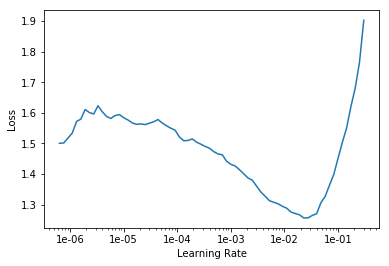

In [59]:
plant_celllearn_101.lr_find(); 
plant_celllearn_101.recorder.plot()

In [14]:
lr = 0.0015 ## taken from min value in above plot
plant_celllearn_101.fit_one_cycle(5, slice(lr))


epoch,train_loss,valid_loss,accuracy
1,1.137809,0.640609,0.766245
2,0.850096,0.528067,0.802347
3,0.750867,0.488866,0.837545
4,0.659280,0.504810,0.829422
5,0.611001,0.485238,0.832130


In [15]:
plant_celllearn_101.save('stage-4-plant_celllearn_101-fast_ai')


In [16]:
plant_celllearn_101.load('stage-4-plant_celllearn_101-fast_ai')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (4436 items)
[Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (4436 items)
[Image (3, 920, 920), Image (3, 744, 744), Image (3, 1289, 1289), Image (3, 511, 511), Image (3, 1546, 1546)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Valid: LabelList
y: CategoryList (1108 items)
[Category Shepherds Purse, Category Common wheat, Category test, Category Sugar beet, Category Common Chickweed]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (1108 items)
[Image (3, 399, 399), Image (3, 113, 113), Image (3, 280, 280), Image (3, 611, 611), Image (3, 140, 140)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), st

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


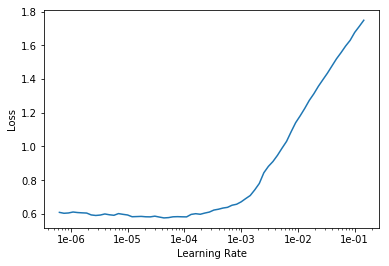

In [17]:
plant_celllearn_101.unfreeze()
plant_celllearn_101.lr_find()
plant_celllearn_101.recorder.plot()

In [18]:
plant_celllearn_101.fit_one_cycle(15, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy
1,0.599381,0.441959,0.840253
2,0.561146,0.428370,0.844765
3,0.543416,0.411323,0.833032
4,0.506398,0.416943,0.844765
5,0.469485,0.359506,0.858303
6,0.445500,0.354326,0.865523
7,0.402825,0.350103,0.850181
8,0.372934,0.322326,0.883574
9,0.365380,0.331664,0.862816
10,0.319682,0.344618,0.863718


In [19]:
plant_celllearn_101.save('stage-5-plant_celllearn_101-fast_ai')

## Progressive Resizing (128 > 256)

In [12]:
plant_celllearn_101.load('stage-5-plant_celllearn_101-fast_ai')
tfms_4 = get_transforms(flip_vert=True, max_lighting=0.7, max_warp=0.)

data_4 = (src_plant.transform(tfms_4, bs=16, size=256)
        .databunch().normalize(imagenet_stats))
data_4.classes
data_4.c
plant_celllearn_101.data = data_4
plant_celllearn_101.freeze()

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (4436 items)
[Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (4436 items)
[Image (3, 920, 920), Image (3, 744, 744), Image (3, 1289, 1289), Image (3, 511, 511), Image (3, 1546, 1546)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Valid: LabelList
y: CategoryList (1108 items)
[Category Shepherds Purse, Category Common wheat, Category test, Category Sugar beet, Category Common Chickweed]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (1108 items)
[Image (3, 399, 399), Image (3, 113, 113), Image (3, 280, 280), Image (3, 611, 611), Image (3, 140, 140)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), st

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'test']

13

In [21]:
plant_celllearn_101.lr_find()


RuntimeError: CUDA error: out of memory

In [ ]:
plant_celllearn_101.recorder.plot()

In [15]:
lr=1e-2

In [18]:
plant_celllearn_101.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,error_rate
1,0.604163,0.334457,0.865523,0.134477
2,0.489692,0.408198,0.842960,0.157040
3,0.497759,0.398481,0.851986,0.148014
4,0.463273,0.322056,0.880866,0.119134
5,0.445229,0.336293,0.863718,0.136282
6,0.405829,0.301261,0.879061,0.120939
7,0.336975,0.300990,0.867329,0.132671
8,0.317469,0.294263,0.885379,0.114621
9,0.296389,0.266200,0.891697,0.108303
10,0.261687,0.266313,0.892599,0.107401


In [22]:
plant_celllearn_101.save('stage-6-plant_celllearn_101-fast_ai')

In [12]:
plant_celllearn_101.load('stage-6-plant_celllearn_101-fast_ai')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (4436 items)
[Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (4436 items)
[Image (3, 920, 920), Image (3, 744, 744), Image (3, 1289, 1289), Image (3, 511, 511), Image (3, 1546, 1546)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Valid: LabelList
y: CategoryList (1108 items)
[Category Shepherds Purse, Category Common wheat, Category test, Category Sugar beet, Category Common Chickweed]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (1108 items)
[Image (3, 399, 399), Image (3, 113, 113), Image (3, 280, 280), Image (3, 611, 611), Image (3, 140, 140)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), st

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


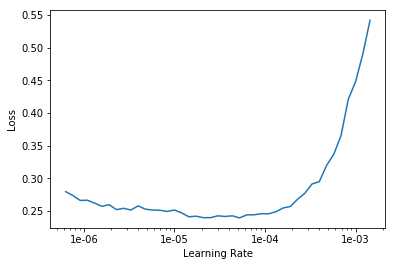

In [13]:
plant_celllearn_101.unfreeze()
plant_celllearn_101.lr_find()
plant_celllearn_101.recorder.plot()

In [16]:
plant_celllearn_101.unfreeze()

In [17]:
plant_celllearn_101.fit_one_cycle(2, slice(1e-05, lr/5))

epoch,train_loss,valid_loss,accuracy
1,0.552823,0.479262,0.805054
2,0.429986,0.299505,0.879964


In [18]:
plant_celllearn_101.fit_one_cycle(5, slice(1e-05, lr/5))

epoch,train_loss,valid_loss,accuracy
1,0.358279,0.389865,0.859206
2,0.459369,0.461851,0.816787
3,0.428052,0.300750,0.877256
4,0.334887,0.263469,0.893502
5,0.282314,0.253286,0.898917


In [26]:
plant_celllearn_101.save('stage-7-plant_celllearn_101-fast_ai')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


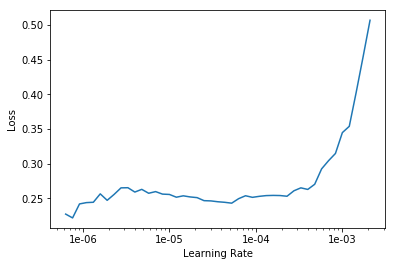

In [19]:
plant_celllearn_101.lr_find()
plant_celllearn_101.recorder.plot()

In [23]:
plant_celllearn_101.freeze()

In [24]:
plant_celllearn_101.freeze_to(-10)  ## here we are unfreezing last 3 three layer

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


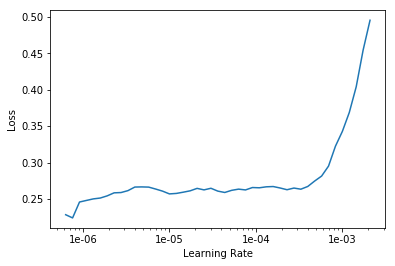

In [23]:
plant_celllearn_101.lr_find()
plant_celllearn_101.recorder.plot()

In [13]:
plant_celllearn_101.load('stage-7-plant_celllearn_101-fast_ai')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (4436 items)
[Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (4436 items)
[Image (3, 920, 920), Image (3, 744, 744), Image (3, 1289, 1289), Image (3, 511, 511), Image (3, 1546, 1546)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Valid: LabelList
y: CategoryList (1108 items)
[Category Shepherds Purse, Category Common wheat, Category test, Category Sugar beet, Category Common Chickweed]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (1108 items)
[Image (3, 399, 399), Image (3, 113, 113), Image (3, 280, 280), Image (3, 611, 611), Image (3, 140, 140)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), st

In [15]:
lr=1e-3

In [16]:
plant_celllearn_101.fit_one_cycle(3, slice(1e-07, lr/5))

epoch,train_loss,valid_loss,accuracy
1,1.104642,0.646295,0.781588
2,0.720224,0.425885,0.827617
3,0.585234,0.398721,0.842058


In [17]:
plant_celllearn_101.save('stage-8-plant_celllearn_101-fast_ai')

In [18]:
plant_celllearn_101.fit_one_cycle(10, slice(1e-07, lr/5))

epoch,train_loss,valid_loss,accuracy
1,0.545339,0.392648,0.842960
2,0.522261,0.369542,0.851986
3,0.480259,0.354841,0.858303
4,0.448070,0.337283,0.865523
5,0.434396,0.329466,0.866426
6,0.424871,0.326353,0.871841
7,0.414811,0.324488,0.861913
8,0.418396,0.316989,0.870939
9,0.401297,0.327062,0.866426
10,0.411343,0.317609,0.865523


In [20]:
plant_celllearn_101.save('stage-9-plant_celllearn_101-fast_ai')

In [21]:
plant_celllearn_101.unfreeze()

In [22]:
plant_celllearn_101.fit_one_cycle(10, slice(1e-07, 1e-06))

epoch,train_loss,valid_loss,accuracy
1,0.413300,0.322777,0.864621
2,0.408766,0.324917,0.859206
3,0.419681,0.324861,0.869134
4,0.405911,0.324720,0.867329
5,0.395649,0.315239,0.868231
6,0.385347,0.319638,0.861913
7,0.388957,0.310091,0.872744
8,0.387241,0.311251,0.870939
9,0.379422,0.310032,0.868231
10,0.382871,0.309895,0.872744


In [25]:
plant_celllearn_101.save('stage-10-plant_celllearn_101-fast_ai')

[('Black-grass', 'Loose Silky-bent', 16),
 ('test', 'Fat Hen', 15),
 ('test', 'Charlock', 11),
 ('test', 'Loose Silky-bent', 10),
 ('test', 'Cleavers', 9),
 ('Small-flowered Cranesbill', 'test', 8),
 ('test', 'Small-flowered Cranesbill', 8),
 ('Fat Hen', 'test', 7),
 ('test', 'Common Chickweed', 7),
 ('Common Chickweed', 'test', 5),
 ('Cleavers', 'test', 4),
 ('Loose Silky-bent', 'Black-grass', 4),
 ('Loose Silky-bent', 'test', 4),
 ('Shepherds Purse', 'test', 4),
 ('test', 'Sugar beet', 3),
 ('Black-grass', 'test', 2),
 ('Shepherds Purse', 'Common Chickweed', 2),
 ('Shepherds Purse', 'Scentless Mayweed', 2),
 ('Sugar beet', 'test', 2),
 ('test', 'Black-grass', 2),
 ('test', 'Scentless Mayweed', 2),
 ('test', 'Shepherds Purse', 2)]

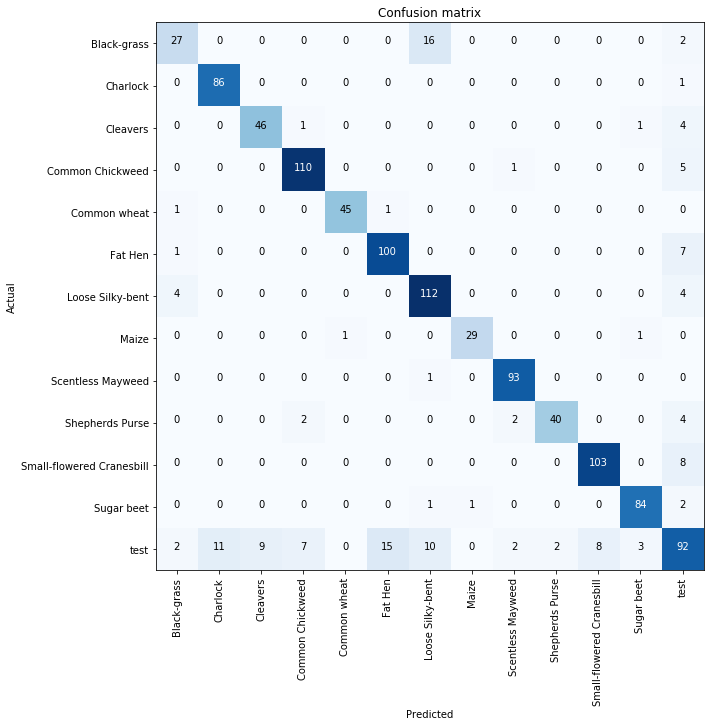

In [27]:
interp = ClassificationInterpretation.from_learner(plant_celllearn_101)
interp.plot_confusion_matrix(figsize=(10,10))
interp.most_confused()

In [28]:
#GenerateTestPredictionAndFile(plant_celllearn_101,'baseline_1plant_seedling_fast_ai_resnet.csv')
imagepreds = []
fileids = []
for file in os.listdir('/home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling/test/'):
    filename = os.path.join('/home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling/test/', file)
    imgtest = open_image(filename)
    predictionarray = plant_celllearn_101.predict(imgtest)
    file
    str(predictionarray[0])
    fileids.append(file)
    imagepreds.append(str(predictionarray[0]))
df = pd.DataFrame({'file':fileids, 'species':imagepreds})
#df.to_csv(TestFileName, index=False,compression='gzip')
df.to_csv('baseline_1plant_seedling_fast_ai_resnet.csv', index=False)
df.head()
    

'76dbd1054.png'

'test'

'9d3cb4745.png'

'test'

'e9cd91682.png'

'Common Chickweed'

'14bb43eee.png'

'test'

'6bce55e05.png'

'test'

'808cf55c6.png'

'test'

'406ecb5c5.png'

'Charlock'

'b7a7f6390.png'

'test'

'caa2fbd79.png'

'test'

'172f9b10b.png'

'test'

'a8de7c1b7.png'

'test'

'7c85b0265.png'

'test'

'a9d2eab61.png'

'Black-grass'

'37714071b.png'

'Shepherds Purse'

'ad12382d4.png'

'test'

'4049a6ea6.png'

'test'

'e15472085.png'

'test'

'606647f64.png'

'test'

'9baf94467.png'

'test'

'39b740f7e.png'

'test'

'80e299ae9.png'

'test'

'25a4c427e.png'

'test'

'55251925f.png'

'test'

'592cc5b89.png'

'test'

'17529c555.png'

'test'

'a800caead.png'

'Sugar beet'

'c74c5b7fc.png'

'test'

'6b9d6f8c9.png'

'test'

'a8da9c08d.png'

'test'

'e721c6ac8.png'

'test'

'1c52ea820.png'

'test'

'33748968f.png'

'Cleavers'

'5ee9d0a5b.png'

'Loose Silky-bent'

'24dbc3b21.png'

'test'

'8f523520c.png'

'Shepherds Purse'

'9b4800b42.png'

'Charlock'

'b573b7a56.png'

'Loose Silky-bent'

'4f83143e1.png'

'test'

'aaf4da98f.png'

'test'

'bb1d1bfd3.png'

'test'

'65d08b894.png'

'test'

'd102e1a15.png'

'test'

'a19c3faca.png'

'Cleavers'

'c7eb96871.png'

'test'

'bebcaab66.png'

'Scentless Mayweed'

'05341a8a6.png'

'test'

'6da892be6.png'

'Small-flowered Cranesbill'

'e96e57a90.png'

'test'

'08d591441.png'

'Sugar beet'

'5eb9c26a6.png'

'test'

'0e8492cb1.png'

'test'

'bf3924a57.png'

'test'

'b5c7fd009.png'

'test'

'c5078bac5.png'

'Loose Silky-bent'

'785a73ab8.png'

'test'

'29bab7cad.png'

'test'

'e783f5a4f.png'

'test'

'dce2f6612.png'

'test'

'00ef713a8.png'

'test'

'f6d250856.png'

'Shepherds Purse'

'24c94a6ca.png'

'test'

'8a30b2de3.png'

'test'

'dcd7ff249.png'

'test'

'0c27cf05f.png'

'test'

'593896f83.png'

'Common Chickweed'

'd2f422ccb.png'

'test'

'3f64c2c1b.png'

'test'

'7615e52d3.png'

'Cleavers'

'486e59179.png'

'Common Chickweed'

'9aa5587fe.png'

'test'

'219fd68d5.png'

'test'

'a35fd6fbb.png'

'test'

'4b032563b.png'

'test'

'126a71ce0.png'

'test'

'187668bde.png'

'test'

'71f5323c5.png'

'test'

'8e6ec1ca6.png'

'Small-flowered Cranesbill'

'46c14fde2.png'

'Loose Silky-bent'

'0c5f6c493.png'

'test'

'0086a6340.png'

'test'

'429211ee6.png'

'Fat Hen'

'506347cfe.png'

'test'

'ffc6f8527.png'

'test'

'86c309150.png'

'test'

'089ad62a7.png'

'Common Chickweed'

'36839d5e9.png'

'test'

'756dd5070.png'

'test'

'fd87b36ae.png'

'Loose Silky-bent'

'cf46d09c5.png'

'Common Chickweed'

'2693e5c65.png'

'test'

'c0461776c.png'

'Common Chickweed'

'8585f9718.png'

'test'

'65e97117e.png'

'Loose Silky-bent'

'8d6991365.png'

'Black-grass'

'd84d37a61.png'

'test'

'6ba4ef411.png'

'test'

'589e643b8.png'

'test'

'686dc7ec8.png'

'test'

'8c9953903.png'

'Fat Hen'

'19fdf19fb.png'

'test'

'5ca0205f9.png'

'test'

'cb76a7766.png'

'Fat Hen'

'0ebf8f2f4.png'

'test'

'7d22abf91.png'

'test'

'a935ca110.png'

'test'

'618de3d7a.png'

'Charlock'

'4e69d100a.png'

'Small-flowered Cranesbill'

'a1da8be3c.png'

'test'

'6edb96d45.png'

'Charlock'

'df11d56a7.png'

'test'

'c5e88cd42.png'

'test'

'668c1007c.png'

'Charlock'

'd41d87796.png'

'test'

'cae684f8f.png'

'Charlock'

'699d3c707.png'

'test'

'085974290.png'

'test'

'490c4f9c8.png'

'Fat Hen'

'8455169fe.png'

'test'

'fda39e16f.png'

'Loose Silky-bent'

'6df8e31ea.png'

'Charlock'

'd488a4fe1.png'

'test'

'856f2910a.png'

'Small-flowered Cranesbill'

'3f92d8039.png'

'Loose Silky-bent'

'07e62f903.png'

'test'

'd93c7ab6d.png'

'test'

'a1e0a6c02.png'

'Cleavers'

'b1cd2a91e.png'

'test'

'f4caf74f9.png'

'Charlock'

'043449b0b.png'

'test'

'f445fe6fb.png'

'Charlock'

'f351ce097.png'

'Loose Silky-bent'

'e73e308be.png'

'test'

'e1a0e3202.png'

'test'

'7cabd68cc.png'

'Loose Silky-bent'

'f4ad9d950.png'

'test'

'3fbd0fc6a.png'

'Common Chickweed'

'da5255450.png'

'test'

'4a337a4a9.png'

'Fat Hen'

'827279bad.png'

'test'

'1b490196c.png'

'test'

'632156793.png'

'Cleavers'

'd14aa43f3.png'

'test'

'0c51bf229.png'

'test'

'ab35453cb.png'

'Cleavers'

'0f6cbe5e8.png'

'test'

'9a3f20121.png'

'test'

'48d97c645.png'

'Small-flowered Cranesbill'

'2d5058a59.png'

'test'

'dc55449b2.png'

'test'

'1459e96a0.png'

'Cleavers'

'ae90f2827.png'

'test'

'966ae5ad9.png'

'Loose Silky-bent'

'9b9911f20.png'

'test'

'c4ed8ed38.png'

'Charlock'

'03e322a29.png'

'Sugar beet'

'edfdb4aeb.png'

'test'

'4ea7493d5.png'

'test'

'19b51843a.png'

'test'

'721b2c47a.png'

'test'

'7b21ba6ba.png'

'Sugar beet'

'dfb1d9012.png'

'test'

'af45e222a.png'

'test'

'958bb9e96.png'

'test'

'e98e5d1d5.png'

'test'

'063363305.png'

'Small-flowered Cranesbill'

'c60e91e07.png'

'test'

'99569b224.png'

'test'

'fe29629fb.png'

'Scentless Mayweed'

'38c054379.png'

'test'

'9d79a1f0c.png'

'Small-flowered Cranesbill'

'adb7a032c.png'

'Loose Silky-bent'

'da231c97f.png'

'test'

'cf90fc52d.png'

'test'

'8cf2e3e6c.png'

'test'

'b026bf8ca.png'

'test'

'9fab816f2.png'

'Fat Hen'

'ef74dbcad.png'

'test'

'ce15eee52.png'

'Charlock'

'36d62bf36.png'

'test'

'33317fc2a.png'

'Fat Hen'

'9326bda1b.png'

'test'

'76555b064.png'

'Loose Silky-bent'

'8c98a6e9b.png'

'test'

'b4c3df835.png'

'test'

'c2de6020a.png'

'test'

'9c32a797e.png'

'test'

'61b044411.png'

'test'

'ec08a5d56.png'

'test'

'31fcdc161.png'

'test'

'a254d71f6.png'

'test'

'752101fdf.png'

'Small-flowered Cranesbill'

'b7ad92859.png'

'test'

'85431c075.png'

'test'

'60fea2ef6.png'

'test'

'2d9c798f9.png'

'test'

'd2f0f326e.png'

'Charlock'

'42e7ed442.png'

'test'

'0ee4ad224.png'

'test'

'1fefb54b7.png'

'test'

'241e6935a.png'

'test'

'592473c83.png'

'Black-grass'

'55fed435f.png'

'test'

'22e79540f.png'

'Cleavers'

'1be0713da.png'

'Cleavers'

'74fd477eb.png'

'test'

'a85b48a95.png'

'test'

'b0acaff4a.png'

'Black-grass'

'a74d475c2.png'

'test'

'446f7da01.png'

'test'

'fea1d13d6.png'

'test'

'279df95f2.png'

'Sugar beet'

'3f826b318.png'

'test'

'd09d24c58.png'

'test'

'b3e08b037.png'

'Fat Hen'

'7fdb7202d.png'

'test'

'dd9f36df7.png'

'test'

'e84464f5a.png'

'Cleavers'

'3d65168c2.png'

'test'

'ace8761dd.png'

'test'

'770a265f5.png'

'Small-flowered Cranesbill'

'003d61042.png'

'test'

'b4f7c9214.png'

'test'

'20817c846.png'

'test'

'b7192c70f.png'

'test'

'b6a3f7876.png'

'Black-grass'

'00c47e980.png'

'test'

'54b3afd58.png'

'Cleavers'

'8a4d3a1b1.png'

'test'

'59c6a9f95.png'

'Fat Hen'

'664194d19.png'

'test'

'523e5505c.png'

'Fat Hen'

'cd6adba97.png'

'Small-flowered Cranesbill'

'52dc7a4d6.png'

'Common Chickweed'

'8e29abce1.png'

'test'

'1926e82fd.png'

'test'

'8d6acbe9b.png'

'test'

'5bdcfa329.png'

'test'

'e88bf0db9.png'

'test'

'23e480e64.png'

'Shepherds Purse'

'59e1cea8d.png'

'Cleavers'

'54c8bb900.png'

'Charlock'

'55a852f40.png'

'test'

'9cce7328c.png'

'test'

'5bd71f445.png'

'test'

'4e1190d78.png'

'test'

'590f5aea6.png'

'Charlock'

'11d3f68ff.png'

'test'

'539961189.png'

'test'

'0021e90e4.png'

'test'

'8a8d6c712.png'

'Cleavers'

'897e5a8de.png'

'Cleavers'

'5a6bf96f6.png'

'test'

'03a2ee656.png'

'test'

'5c3cd7ea2.png'

'test'

'41e07778c.png'

'Cleavers'

'1758a1baf.png'

'test'

'835dc5447.png'

'test'

'223e4af09.png'

'Cleavers'

'1694a70e4.png'

'test'

'19e58cc5e.png'

'Common Chickweed'

'78c5fba1d.png'

'test'

'90b595f12.png'

'Common Chickweed'

'63c07d340.png'

'test'

'5e6a237f2.png'

'test'

'cec5bf198.png'

'test'

'1364b297a.png'

'Cleavers'

'fadc6adbc.png'

'test'

'a83820a2c.png'

'Sugar beet'

'f1f7c833f.png'

'test'

'3efa1f66c.png'

'test'

'f4021df6c.png'

'Fat Hen'

'0caeda5df.png'

'test'

'b341d0aab.png'

'test'

'e0ec5b6a1.png'

'Sugar beet'

'4823c3ffa.png'

'test'

'0ad9e7dfb.png'

'test'

'a8388a37f.png'

'Fat Hen'

'a0b393945.png'

'test'

'e901b0f28.png'

'test'

'33448fe39.png'

'test'

'74068643d.png'

'Loose Silky-bent'

'c35efa095.png'

'test'

'c10db7ae2.png'

'test'

'dc4cd56a3.png'

'test'

'ef7a5651d.png'

'test'

'377283a21.png'

'Maize'

'afa446484.png'

'Small-flowered Cranesbill'

'8e3ed0a25.png'

'Small-flowered Cranesbill'

'8cf909eb3.png'

'Charlock'

'3526b05cc.png'

'test'

'd17f48d3b.png'

'test'

'f4e7733d4.png'

'test'

'c10ccbd82.png'

'test'

'604dd663f.png'

'Shepherds Purse'

'653193c1a.png'

'test'

'b30ab4659.png'

'Cleavers'

'270b939cf.png'

'test'

'1541bdb2e.png'

'test'

'a74bf916d.png'

'Shepherds Purse'

'e19673dc9.png'

'test'

'a8b431a3e.png'

'Sugar beet'

'b39c71707.png'

'test'

'2a667e099.png'

'test'

'dabe3e5be.png'

'Small-flowered Cranesbill'

'1191ba346.png'

'Cleavers'

'5a38ac566.png'

'test'

'19618ad6a.png'

'test'

'41f1c3cdb.png'

'Fat Hen'

'8cfd98117.png'

'test'

'a544fc46d.png'

'test'

'8ca6140ca.png'

'test'

'e5881dd33.png'

'test'

'79dafec17.png'

'test'

'8ab8a958b.png'

'Fat Hen'

'02cfeb38d.png'

'test'

'0885e7690.png'

'test'

'29ce426a1.png'

'test'

'73260a4ee.png'

'Fat Hen'

'df521c0c0.png'

'Loose Silky-bent'

'b98327bf4.png'

'test'

'cadab6616.png'

'Shepherds Purse'

'f9f35cbd4.png'

'test'

'24a058589.png'

'Charlock'

'cf3a8b2fd.png'

'test'

'f3fcfff1b.png'

'Cleavers'

'b130a0632.png'

'Cleavers'

'2f246d688.png'

'Small-flowered Cranesbill'

'f593c9cf0.png'

'test'

'71b232519.png'

'test'

'e4d5ec761.png'

'test'

'4c5ab9b68.png'

'Cleavers'

'6d6eb3830.png'

'test'

'67ce3eaa6.png'

'Small-flowered Cranesbill'

'e19ad6ac9.png'

'Charlock'

'f8318faf1.png'

'test'

'ef3e232ad.png'

'test'

'ac3193f78.png'

'test'

'd689256be.png'

'test'

'1dc7c45df.png'

'test'

'c50335991.png'

'Fat Hen'

'fc6f686fb.png'

'test'

'a2c89c367.png'

'test'

'eaf0815e2.png'

'Small-flowered Cranesbill'

'35a90f8d0.png'

'test'

'148bbda66.png'

'Charlock'

'48ef6a2ff.png'

'test'

'974959ec1.png'

'test'

'97b2f0a10.png'

'test'

'8104422bb.png'

'test'

'e1809cef2.png'

'Scentless Mayweed'

'3a909ead8.png'

'Small-flowered Cranesbill'

'4bbfd1e05.png'

'Cleavers'

'26852751a.png'

'Charlock'

'cbba27d89.png'

'test'

'aecfaed64.png'

'test'

'a0f37c726.png'

'test'

'550a8b7e6.png'

'test'

'c75a82234.png'

'test'

'0751c0bbc.png'

'test'

'3da774107.png'

'Fat Hen'

'61dd2cdc5.png'

'test'

'8a32d0bfa.png'

'test'

'67e185673.png'

'test'

'acdb75e00.png'

'Loose Silky-bent'

'f23faf9c1.png'

'test'

'1623fb9e1.png'

'test'

'6049234e6.png'

'test'

'8170d33c1.png'

'test'

'205df1df3.png'

'Fat Hen'

'20ea96bcc.png'

'Fat Hen'

'f66ae4070.png'

'test'

'59b2c6f2b.png'

'test'

'd0152bd7c.png'

'test'

'ef65533d5.png'

'Loose Silky-bent'

'165681fd9.png'

'Cleavers'

'466bb6d3b.png'

'test'

'3bbef3ecb.png'

'test'

'ef02b4ee7.png'

'test'

'98062cd87.png'

'test'

'5f04aed97.png'

'test'

'7d3045fc3.png'

'Sugar beet'

'976e4e079.png'

'test'

'7696badea.png'

'Black-grass'

'e5297b675.png'

'test'

'969a851be.png'

'test'

'728eabae1.png'

'Charlock'

'862b8e7a0.png'

'test'

'60ee66ddd.png'

'Cleavers'

'65489944f.png'

'test'

'47b7d8e17.png'

'test'

'5883b423d.png'

'test'

'03566743d.png'

'test'

'5b3beec58.png'

'Loose Silky-bent'

'24d36c52c.png'

'Common Chickweed'

'a2d25b4f3.png'

'Small-flowered Cranesbill'

'2dd5cfba9.png'

'test'

'391dcd7fd.png'

'test'

'0ae6668fa.png'

'test'

'dd5ec63d9.png'

'test'

'82b5f4d33.png'

'Cleavers'

'cc74feadc.png'

'test'

'3b73c3b61.png'

'test'

'060450d79.png'

'test'

'f85ed9b6d.png'

'test'

'0c45ace27.png'

'test'

'bfab3e3d0.png'

'test'

'8e2e5604e.png'

'test'

'abf8b0772.png'

'test'

'4b155fb07.png'

'test'

'5af1d74ee.png'

'test'

'99036c51d.png'

'test'

'a890ac088.png'

'Charlock'

'659412b1a.png'

'test'

'22fbf13d6.png'

'test'

'3e9f41817.png'

'test'

'd89db156f.png'

'Small-flowered Cranesbill'

'4bbf1f6ea.png'

'test'

'7506c0c02.png'

'test'

'30ad31220.png'

'Charlock'

'be341dbdc.png'

'test'

'6db684fff.png'

'test'

'35cf9fa01.png'

'Shepherds Purse'

'55920f07f.png'

'test'

'b6f3d8b5d.png'

'test'

'177d7e2a4.png'

'test'

'04814f36d.png'

'test'

'abc331628.png'

'test'

'c06e7c748.png'

'Scentless Mayweed'

'f0ffa00bd.png'

'test'

'c0f5d9ac8.png'

'test'

'ce42adffb.png'

'test'

'3ebbe9ca4.png'

'Charlock'

'9c8b08a24.png'

'Loose Silky-bent'

'ab0f67743.png'

'test'

'647689543.png'

'Loose Silky-bent'

'cb496f36e.png'

'test'

'ff65bc002.png'

'test'

'8b9144917.png'

'Small-flowered Cranesbill'

'675ec1b0b.png'

'Small-flowered Cranesbill'

'87608f7aa.png'

'test'

'7b52585da.png'

'Loose Silky-bent'

'5296835a0.png'

'Small-flowered Cranesbill'

'98d819587.png'

'test'

'780defa2e.png'

'test'

'837ac0270.png'

'test'

'65e262a6d.png'

'Charlock'

'808578ed5.png'

'test'

'd01873fdd.png'

'Loose Silky-bent'

'410e6f702.png'

'test'

'35ebe165c.png'

'Black-grass'

'26e7ae885.png'

'test'

'c7b07431e.png'

'test'

'0bf7bfb05.png'

'test'

'bb64660b7.png'

'test'

'b62dca166.png'

'test'

'a85fc8c9a.png'

'Small-flowered Cranesbill'

'953496deb.png'

'Fat Hen'

'31f3dd81f.png'

'test'

'ef9676433.png'

'Charlock'

'd6c8c3c48.png'

'test'

'4e9d3765f.png'

'Charlock'

'a55d26a4c.png'

'test'

'c0d9e170b.png'

'Small-flowered Cranesbill'

'17a78fb44.png'

'test'

'32a8c8a1d.png'

'Loose Silky-bent'

'75cb95e91.png'

'Charlock'

'3abb502fb.png'

'test'

'79fba50db.png'

'Common Chickweed'

'be2499cf4.png'

'test'

'ac75d3326.png'

'test'

'995c7ab1e.png'

'test'

'5b63dcc21.png'

'test'

'6edc76e7c.png'

'Fat Hen'

'fda0b5c38.png'

'test'

'6a41bf95b.png'

'test'

'e5368474f.png'

'test'

'87f627bf9.png'

'test'

'79d93bc96.png'

'test'

'16fd2e01a.png'

'test'

'17d5e5ac4.png'

'test'

'fd925f542.png'

'test'

'12625488b.png'

'Fat Hen'

'beebe5f4e.png'

'test'

'9c777333d.png'

'Common Chickweed'

'6908fb540.png'

'test'

'5779fe8b4.png'

'Fat Hen'

'69d1669f8.png'

'test'

'd7017f701.png'

'Fat Hen'

'59f62ad1d.png'

'test'

'e14afa235.png'

'test'

'1bf9b94a6.png'

'test'

'bd72d4d8a.png'

'test'

'cc3d2a59a.png'

'test'

'c88ebfb47.png'

'test'

'0911d3dee.png'

'test'

'0c4199daa.png'

'test'

'8ece6efec.png'

'test'

'4c8005bbc.png'

'test'

'f9ea23fb5.png'

'test'

'de0b79659.png'

'test'

'c63da993b.png'

'test'

'1f3f44563.png'

'test'

'c7051c902.png'

'Common Chickweed'

'8303b27ed.png'

'Loose Silky-bent'

'800a8c17e.png'

'Fat Hen'

'25fa8d109.png'

'test'

'1821eb11a.png'

'Scentless Mayweed'

'3185294c8.png'

'test'

'288564c76.png'

'test'

'3eebd36c6.png'

'Charlock'

'd5f7dd60a.png'

'test'

'c0bc3997b.png'

'test'

'dabea05f4.png'

'test'

'bdde957ec.png'

'test'

'fd253a74e.png'

'Cleavers'

'615d2b0a9.png'

'test'

'007b3da8b.png'

'test'

'0437393b1.png'

'test'

'44e8b8833.png'

'Small-flowered Cranesbill'

'a3b375b34.png'

'test'

'2ea664465.png'

'Sugar beet'

'da9ef7858.png'

'Charlock'

'aa7d098d1.png'

'test'

'8dbb8e1b9.png'

'test'

'6b721f68e.png'

'test'

'e6f1211a2.png'

'Sugar beet'

'03ef36742.png'

'test'

'71334c634.png'

'test'

'239bdf640.png'

'test'

'cfb18d262.png'

'test'

'3eda9cbb6.png'

'test'

'338c7e907.png'

'Charlock'

'6680836dd.png'

'test'

'd350a25fa.png'

'Common Chickweed'

'8b27bfd2b.png'

'Small-flowered Cranesbill'

'b944a49ca.png'

'test'

'aee6fa3df.png'

'test'

'8faadb6a8.png'

'test'

'2b55a2da2.png'

'test'

'a7bd7cadb.png'

'Fat Hen'

'66ab0e8d0.png'

'Charlock'

'521b27a17.png'

'test'

'bea23d9f8.png'

'test'

'71e73a8a0.png'

'Sugar beet'

'2e86f1085.png'

'Fat Hen'

'e52493d0b.png'

'test'

'56112b92c.png'

'test'

'534e74d83.png'

'test'

'502dff972.png'

'Small-flowered Cranesbill'

'6c874918c.png'

'test'

'e471f1d3a.png'

'test'

'96ecad7a1.png'

'test'

'8916793ce.png'

'test'

'4287d810c.png'

'test'

'32b42c120.png'

'Small-flowered Cranesbill'

'3827436f3.png'

'test'

'fe9e87b78.png'

'test'

'd668409ff.png'

'test'

'7f46a71db.png'

'test'

'df7cb5f87.png'

'test'

'cd5f0db1c.png'

'Small-flowered Cranesbill'

'd563be369.png'

'Fat Hen'

'0d117d910.png'

'test'

'78b1bf91a.png'

'test'

'7f9e9565d.png'

'test'

'7f31c7f42.png'

'test'

'c64370a72.png'

'test'

'c6b76307d.png'

'Cleavers'

'b03397525.png'

'test'

'060f1dc84.png'

'test'

'39858776a.png'

'Cleavers'

'16467a950.png'

'Loose Silky-bent'

'4e18ab737.png'

'Cleavers'

'b29339405.png'

'test'

'bf66b9cd2.png'

'test'

'a3d0031fd.png'

'Loose Silky-bent'

'9516e56c4.png'

'Black-grass'

'fba8fc78a.png'

'Loose Silky-bent'

'cfd8165e9.png'

'Charlock'

'099b961ec.png'

'test'

'56a01b835.png'

'Cleavers'

'6a47821f9.png'

'test'

'20e562fd5.png'

'Sugar beet'

'bb1c84bbc.png'

'test'

'50de8a115.png'

'test'

'7beb2766f.png'

'test'

'25cf6eb73.png'

'test'

'8874bba69.png'

'Loose Silky-bent'

'2df78338c.png'

'test'

'a38b8a581.png'

'test'

'0d31e6602.png'

'test'

'da713c465.png'

'test'

'64fe8beb9.png'

'test'

'a276c65f7.png'

'test'

'd9c50616e.png'

'test'

'a2b703e21.png'

'test'

'8b043093d.png'

'Small-flowered Cranesbill'

'c1ecff98b.png'

'test'

'3281183f9.png'

'test'

'e5e3dccff.png'

'test'

'892e9d6c6.png'

'test'

'fea355851.png'

'test'

'248436078.png'

'Cleavers'

'fdea6b119.png'

'test'

'9df3275da.png'

'Small-flowered Cranesbill'

'8301b0547.png'

'Charlock'

'3d38a87bc.png'

'test'

'f9b6bfb00.png'

'Cleavers'

'a169b71e7.png'

'test'

'7691014a1.png'

'test'

'59358cd44.png'

'test'

'f4234cf4f.png'

'Fat Hen'

'f2dc546ca.png'

'Cleavers'

'2d992d1fb.png'

'test'

'a060c1cf8.png'

'test'

'e7077322d.png'

'test'

'6dd095129.png'

'Common Chickweed'

'116b136de.png'

'test'

'b47691c08.png'

'Scentless Mayweed'

'7a38416be.png'

'Charlock'

'824f5d4e5.png'

'test'

'8bc0261c9.png'

'test'

'9643fc5f4.png'

'Charlock'

'f48916a8c.png'

'test'

'1376f3b63.png'

'test'

'599691cd9.png'

'test'

'c069fc3fa.png'

'test'

'37297a64c.png'

'test'

'b3d6fdb80.png'

'test'

'96f14d90c.png'

'test'

'558aa7deb.png'

'test'

'851c90831.png'

'test'

'29f49cd0b.png'

'Fat Hen'

'2406d6c99.png'

'Shepherds Purse'

'48231e475.png'

'test'

'79e5ea8fa.png'

'test'

'88ac6df54.png'

'Loose Silky-bent'

'8e4eaeec0.png'

'test'

'24d78df74.png'

'test'

'1d321253f.png'

'Fat Hen'

'809eb0b82.png'

'test'

'cbe761896.png'

'test'

'1b6a6494d.png'

'test'

'948cdb277.png'

'Cleavers'

'1cfd91582.png'

'Charlock'

'754b1adf8.png'

'Small-flowered Cranesbill'

'a8c8a1db0.png'

'test'

'4bcdaa5e2.png'

'test'

'bffc08672.png'

'test'

'4f44ca525.png'

'Common Chickweed'

'd515398fd.png'

'test'

'122913909.png'

'test'

'37c3108d6.png'

'test'

'c5e419015.png'

'Scentless Mayweed'

'ce3d280eb.png'

'test'

'599c82eea.png'

'test'

'60f0bc617.png'

'test'

'd2fd9df40.png'

'Loose Silky-bent'

'c6c8d4ba0.png'

'test'

'780bd2a2c.png'

'test'

'1312065a5.png'

'test'

'00d090cde.png'

'test'

'c85ef220d.png'

'test'

'fb022edf9.png'

'test'

'd8f4923f8.png'

'test'

'5bc6595f6.png'

'test'

'e921021a8.png'

'Fat Hen'

'fbf88b6be.png'

'Charlock'

'0dba99002.png'

'test'

'8311740de.png'

'test'

'fea3da57c.png'

'test'

'0625f063b.png'

'test'

'1f5e5554e.png'

'Small-flowered Cranesbill'

'071cb3ece.png'

'test'

'f25996db8.png'

'Small-flowered Cranesbill'

'a4b61a4ea.png'

'Loose Silky-bent'

'06d12f6fa.png'

'Shepherds Purse'

'c832e4302.png'

'Fat Hen'

'39d569be4.png'

'test'

'5bbc0a255.png'

'test'

'7d4cd07ad.png'

'Common Chickweed'

'e80a259c5.png'

'Small-flowered Cranesbill'

'a006a475c.png'

'test'

'1d48b7564.png'

'test'

'13b9fa92d.png'

'test'

'90d119d25.png'

'test'

'ede6b84b4.png'

'Cleavers'

'3d67c434b.png'

'Fat Hen'

'efe19dc32.png'

'test'

'0a64e3e6c.png'

'test'

'01291174f.png'

'Fat Hen'

'd0cdc768f.png'

'test'

'2bd74d2da.png'

'test'

'9c0c5b731.png'

'Loose Silky-bent'

'86676d627.png'

'Fat Hen'

'5315c2dca.png'

'test'

'34dd57ca9.png'

'test'

'20f983a71.png'

'Fat Hen'

'721be0a4a.png'

'Loose Silky-bent'

'98da6ef4e.png'

'test'

'4392d93cf.png'

'test'

'afcf6abd5.png'

'test'

'91e469b4a.png'

'Charlock'

'eec1079a1.png'

'test'

'd09275360.png'

'test'

'1d56351b2.png'

'Common Chickweed'

'6982a9d30.png'

'Small-flowered Cranesbill'

'd6d80a321.png'

'test'

'2f0004a7f.png'

'Common wheat'

'39c8fde99.png'

'test'

'5ca2687a4.png'

'test'

'bd789d151.png'

'test'

'5dcad9a53.png'

'test'

'e5064f6be.png'

'test'

'b828443ff.png'

'Maize'

'32c86784b.png'

'Common Chickweed'

'd3331e071.png'

'test'

'1c680883c.png'

'Loose Silky-bent'

'115f93ecc.png'

'test'

'e3f50adfc.png'

'Cleavers'

'963544aa0.png'

'test'

'b215531dd.png'

'test'

'86f08e6d1.png'

'Fat Hen'

'fa9f3a8f9.png'

'Cleavers'

'6be169e41.png'

'test'

'd6d31dcbe.png'

'test'

'78750e0ff.png'

'Charlock'

'5b3000b9a.png'

'test'

'52a87abe5.png'

'Fat Hen'

'866be78b0.png'

'test'

'77ccb8b2a.png'

'Small-flowered Cranesbill'

'f33e9d918.png'

'test'

'3edf5e9ef.png'

'test'

'4c7838de4.png'

'test'

'c26ccf73c.png'

'Common Chickweed'

'1d0cbd819.png'

'Loose Silky-bent'

'bb7621cb3.png'

'test'

'b145ba9d4.png'

'test'

'8db450ce3.png'

'test'

'16357b436.png'

'Loose Silky-bent'

'5817b766d.png'

'Shepherds Purse'

'855955aaf.png'

'Small-flowered Cranesbill'

'93d76fd5d.png'

'test'

'b31292706.png'

'Common Chickweed'

'92292055d.png'

'test'

'eef131644.png'

'Loose Silky-bent'

'23bc8ec4f.png'

'test'

'7e9cf1c46.png'

'test'

'444473900.png'

'Fat Hen'

'406162ef9.png'

'Charlock'

'e9d48d664.png'

'test'

'36ed4f215.png'

'test'

'bb20fce02.png'

'test'

'da4ed3a28.png'

'Charlock'

'026716f9b.png'

'test'

'e478c452c.png'

'test'

'f1e87cba7.png'

'test'

'93079d970.png'

'test'

'a93f940d6.png'

'test'

'b2706e2b3.png'

'test'

'456d507c0.png'

'Cleavers'

'c8f50f0c3.png'

'test'

'53ceb4657.png'

'test'

'e1abb4ff9.png'

'test'

'c7ae30f3a.png'

'test'

'88d8a4508.png'

'Fat Hen'

'43ede9de9.png'

'Charlock'

'e15fce4f2.png'

'test'

'2126dc71b.png'

'test'

'a5db42f7d.png'

'test'

'fa5fd1384.png'

'Shepherds Purse'

'37e545a60.png'

'Common Chickweed'

'3fbf1a417.png'

'test'

'4ac29bbf0.png'

'test'

'74d810f87.png'

'Loose Silky-bent'

'47f9e5d91.png'

'Common Chickweed'

'b687160f5.png'

'test'

'3dd52bd2a.png'

'test'

'1f290e016.png'

'test'

'e4a76885b.png'

'test'

'2ff5cb348.png'

'test'

'2a5064f19.png'

'Common wheat'

'1e095a7e1.png'

'test'

'0fb233ad6.png'

'Small-flowered Cranesbill'

'b9062c1c8.png'

'test'

'ba3ce6b3e.png'

'test'

'711b46fba.png'

'Shepherds Purse'

'fef2ade8c.png'

'test'

'258b1183c.png'

'Cleavers'

'aad8375e0.png'

'test'

'97844bfd5.png'

'Shepherds Purse'

'e82017baa.png'

'test'

'fc3e58836.png'

'test'

'53e6e9000.png'

'test'

,file,species
0,76dbd1054.png,test
1,9d3cb4745.png,test
2,e9cd91682.png,Common Chickweed
3,14bb43eee.png,test
4,6bce55e05.png,test


## Progressive Resizing (256 > 224)

In [29]:
plant_celllearn_101.load('stage-10-plant_celllearn_101-fast_ai')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (4436 items)
[Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (4436 items)
[Image (3, 920, 920), Image (3, 744, 744), Image (3, 1289, 1289), Image (3, 511, 511), Image (3, 1546, 1546)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Valid: LabelList
y: CategoryList (1108 items)
[Category Shepherds Purse, Category Common wheat, Category test, Category Sugar beet, Category Common Chickweed]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (1108 items)
[Image (3, 399, 399), Image (3, 113, 113), Image (3, 280, 280), Image (3, 611, 611), Image (3, 140, 140)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), st

In [30]:
#plant_celllearn_101.load('stage-5-plant_celllearn_101-fast_ai')

tfms_5 = get_transforms(flip_vert=True, max_lighting=0.7, max_warp=0.)

data_5 = (src_plant.transform(tfms_4, bs=16, size=224)
        .databunch().normalize(imagenet_stats))


# tfms_5 = get_transforms(flip_vert=True, max_lighting=0.5, max_warp=0.)

# data_5 = (src_plant.transform(tfms_5, bs=16, size=256)
#         .databunch(bs=16).normalize(imagenet_stats))
data_5.classes
data_5.c
plant_celllearn_101.data = data_5
plant_celllearn_101.freeze()
plant_celllearn_101.crit = 'CrossEntropyLoss'


['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'test']

13

In [31]:
plant_celllearn_101.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


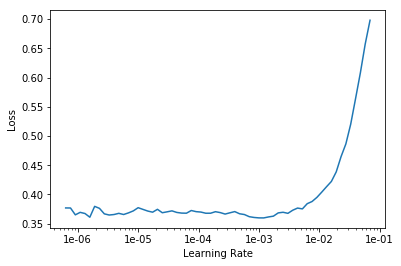

In [32]:
plant_celllearn_101.recorder.plot()

In [33]:
lr=1e-3
plant_celllearn_101.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy
1,0.358005,0.306397,0.873646
2,0.366465,0.321569,0.870939
3,0.364898,0.308653,0.871841
4,0.332226,0.292447,0.884477
5,0.316161,0.290187,0.881769


In [34]:
plant_celllearn_101.unfreeze()

In [57]:
plant_celllearn_101.fit_one_cycle(10, slice(1e-06, lr/5))

epoch,train_loss,valid_loss,accuracy
1,0.217084,0.274144,0.895307
2,0.217529,0.282573,0.891697
3,0.238252,0.296328,0.884477
4,0.227515,0.311445,0.880866
5,0.226270,0.307705,0.881769
6,0.210381,0.293696,0.888087
7,0.203054,0.297964,0.882671


KeyboardInterrupt: 

Note that the other layers have already been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as differential learning rates, although there's no standard name for this techique in the literature that we're aware of.

In [37]:
plant_celllearn_101.save('stage-10-plant_celllearn_101-fast_ai')

#### Easy steps to train a world-class image classifier

- precompute=True
- Use lr_find() to find highest learning rate where loss is still clearly improving
- Train last layer from precomputed activations for 1-2 epochs
- Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
- Unfreeze all layers
- Set earlier layers to 3x-10x lower learning rate than next higher layer
- Use lr_find() again
- Train full network with cycle_mult=2 until over-fitting

In [55]:
plant_celllearn_101.load('stage-10-plant_celllearn_101-fast_ai')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (4436 items)
[Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet, Category Sugar beet]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (4436 items)
[Image (3, 920, 920), Image (3, 744, 744), Image (3, 1289, 1289), Image (3, 511, 511), Image (3, 1546, 1546)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Valid: LabelList
y: CategoryList (1108 items)
[Category Shepherds Purse, Category Common wheat, Category test, Category Sugar beet, Category Common Chickweed]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling
x: ImageItemList (1108 items)
[Image (3, 399, 399), Image (3, 113, 113), Image (3, 280, 280), Image (3, 611, 611), Image (3, 140, 140)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/plant-seedling;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), st

In [54]:
# plant_celllearn_101.lr_range(slice(1e-7,1e-4))
# plant_celllearn_101.fit(5)
#plant_celllearn_101.fit_one_cycle(10, slice(1e-06, lr/5))

array([1.000000e-07, 3.162278e-06, 1.000000e-04])

epoch,train_loss,valid_loss,accuracy
1,0.747597,0.483984,0.818592


Traceback (most recent call last):
  File "/home/nbuser/.anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/nbuser/.anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/nbuser/.anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/nbuser/.anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/nbuser/.anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/nbuser/.anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/nbuser/.anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
   

KeyboardInterrupt: 

There is something else we can do with data augmentation: use it at inference time (also known as test time). Not surprisingly, this is known as test time augmentation, or just TTA.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's TTA() method.
I generally see about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!

In [56]:
log_preds,y = plant_celllearn_101.TTA()
# probs = np.mean(np.exp(log_preds),0)
# accuracy_np(probs, y)


TypeError: mean() missing 3 required positional argument: "dim", "keepdim", "dtype"

In [ ]:
plant_celllearn_101.fit_one_cycle(10, slice(1e-06, lr/5))

#### Analyzing results: loss and accuracy
When we run learn.fit we print 3 performance values (see above.) Here 0.03 is the value of the loss in the training set, 0.0226 is the value of the loss in the validation set and 0.9927 is the validation accuracy. What is the loss? What is accuracy? Why not to just show accuracy?

Accuracy is the ratio of correct prediction to the total number of predictions.

In machine learning the loss function or cost function is representing the price paid for inaccuracy of predictions.

The loss associated with one example in binary classification is given by: -(y * log(p) + (1-y) * log (1-p)) where y is the true label of x and p is the probability predicted by our model that the label is 1.

Note that in our toy example above our accuracy is 100% and our loss is 0.16. Compare that to a loss of 0.03 that we are getting while predicting cats and dogs. Exercise: play with `preds` to get a lower loss for this example. 

**Example:** Here is an example on how to compute the loss for one example of binary classification problem. Suppose for an image x with label 1 and your model gives it a prediction of 0.9. For this case the loss should be small because our model is predicting a label $1$ with high probability.

`loss = -log(0.9) = 0.10`

Now suppose x has label 0 but our model is predicting 0.9. In this case our loss should be much larger.

loss = -log(1-0.9) = 2.30

- Exercise: look at the other cases and convince yourself that this make sense.
- Exercise: how would you rewrite `binary_loss` using `if` instead of `*` and `+`?

Why not just maximize accuracy? The binary classification loss is an easier function to optimize.